# NIAID DIR Section Similarity

This notebook concatenates the data sets produced from the table results of Jaccard Similarity in Neo4j. The data sets were combined for later transformation in to a similarity matrix for visualization and consumption. To that end, the script outputs a pairwise similarity table and two similarity matrix plots. In order to obtain the data, this notebook utilizes CSV files that have been exported from Neo4j. It includes the following features of substantive interest.

### Data Features
1. **Section A** (object): A given lab section name.
2. **Section B** (object): A given lab section name, not including duplicates from Section A.
3. **Journal Category** (float64): Lab section similarity measured by publications sharing the same journal category.
4. **Journal Title** (float64): Lab section similarity measured by publications that have appeared in the same journal
5. **Keyword** (float64): Lab section similarity measured by publications containing the same keyword.
6. **MeSH** (float64): Lab section similarity measured by publications containing the same Medical Subject Heading (MeSH).
7. **Paper** (float64): Lab section similarity measured by co-authored publications.
8. **Project Category** (float64): Lab section similarity measured by projects with overlapping project spending categories.
9. **Project Term** (float64):** Lab section similarity measured by projections with overlapping terms.
10. **Normal Inverse Distance** (float64): Normalized n-Dimensional Inverse Euclidean Distance, used for combining individual measurements of similarity.

    _Note: Lab section name features (1 to 2) contain string values. Lab section similarity features (3 to 10) contain float values bound between 0 and 1. Length, n = 12880 (non-null)._

### Depdendencies
1. **Python** (3.8.2): Language
2. **NumPy** (1.21.4): Scientific computing
3. **Pandas** (1.2.4): Dataframes for data manipulation
4. **Matplotlib** (3.5.1): Data visualization
5. **Seaborn** (0.11.2): Data visualization

In [44]:
## libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import dist

### Data

In [45]:
## load data
data_path = '../data/sec-sim/'
data_file = os.listdir(data_path)

feat = [
    'section_a', 
    'section_b'
]

data = pd.DataFrame(
    columns = feat
)

for i in data_file:
    data_right = pd.read_csv(
        filepath_or_buffer = data_path + i
    )

    data = data.merge(
        right = data_right,
        how = 'outer',
        on = feat
    )

## pre-process data
data.fillna(
    value = 0,
    inplace = True
)


### Normalized n-Dimensional Inverse Euclidean Distance

In [46]:
## get dims
i = 2
n = len(data)
m = len(data.columns)

## calc max dist
max_pts = list(
    np.full(
    shape = m - i,
    fill_value = 1.00
    )
)

min_pts = list(
    np.zeros(m - i)
)

max_dist = dist(max_pts, min_pts)

## calc inverse euclid distance
feat_dist = 'inv_dist'
data[feat_dist] = 0.00

for j in range(0, n):
    data.loc[j, feat_dist] = (
        max_dist - dist(max_pts, list(data.iloc[j, i:m]))
    )

## norm inverse euclid distance
feat_dist_norm = 'norm_' + feat_dist
data[feat_dist_norm] = (
    (data[feat_dist] - data[feat_dist].min()) / 
    (data[feat_dist].max() - data[feat_dist].min())
)

data.drop(
    columns = feat_dist,
    inplace = True
)

### Post-Process

In [47]:
## sorting
data.sort_values(
    by = feat_dist_norm,
    ascending = False,
    inplace = True
)

## feature names
feat_name = {
    'section_a': 'Section A',
    'section_b': 'Section B',
    'journal_cat_similarity': 'Journal Category',
    'journal_similarity': 'Journal Title',
    'keyword_similarity': 'Keyword',
    'mesh_similarity': 'MeSH',
    'paper_similarity': 'Paper',
    'project_cat_similarity': 'Project Category',
    'project_term_similarity': 'Project Term',
    'norm_inv_dist': 'Normal Inverse Distance'
}

data.rename(
    columns = feat_name,
    inplace = True
)

## data preview
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12880 entries, 0 to 12867
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Section A                12880 non-null  object 
 1   Section B                12880 non-null  object 
 2   Journal Category         12880 non-null  float64
 3   Journal Title            12880 non-null  float64
 4   Keyword                  12880 non-null  float64
 5   MeSH                     12880 non-null  float64
 6   Paper                    12880 non-null  float64
 7   Project Category         12880 non-null  float64
 8   Project Term             12880 non-null  float64
 9   Normal Inverse Distance  12880 non-null  float64
dtypes: float64(8), object(2)
memory usage: 1.1+ MB


### Export

In [48]:
## data to disk
data.to_csv(
    path_or_buf = '../data/niaid-dir-sec-sim.csv',
    index = False
)

### Subset

In [49]:
## subset by n
data_subs = data.head(
    n = 25
)

## reindex
data_subs.reset_index(
    drop = True,
    inplace = True
)

### Transform

In [50]:
## cast pairwise feat to matrix
data_mtrx = data.pivot(
    index = 'Section A',
    columns = 'Section B',
    values = 'Normal Inverse Distance'
)

data_subs_mtrx = data_subs.pivot(
    index = 'Section A',
    columns = 'Section B',
    values = 'Normal Inverse Distance'
)

## impute implied zeros
data_mtrx.fillna(
    value = 0,
    inplace = True
)

data_subs_mtrx.fillna(
    value = 0,
    inplace = True
)


### Plot

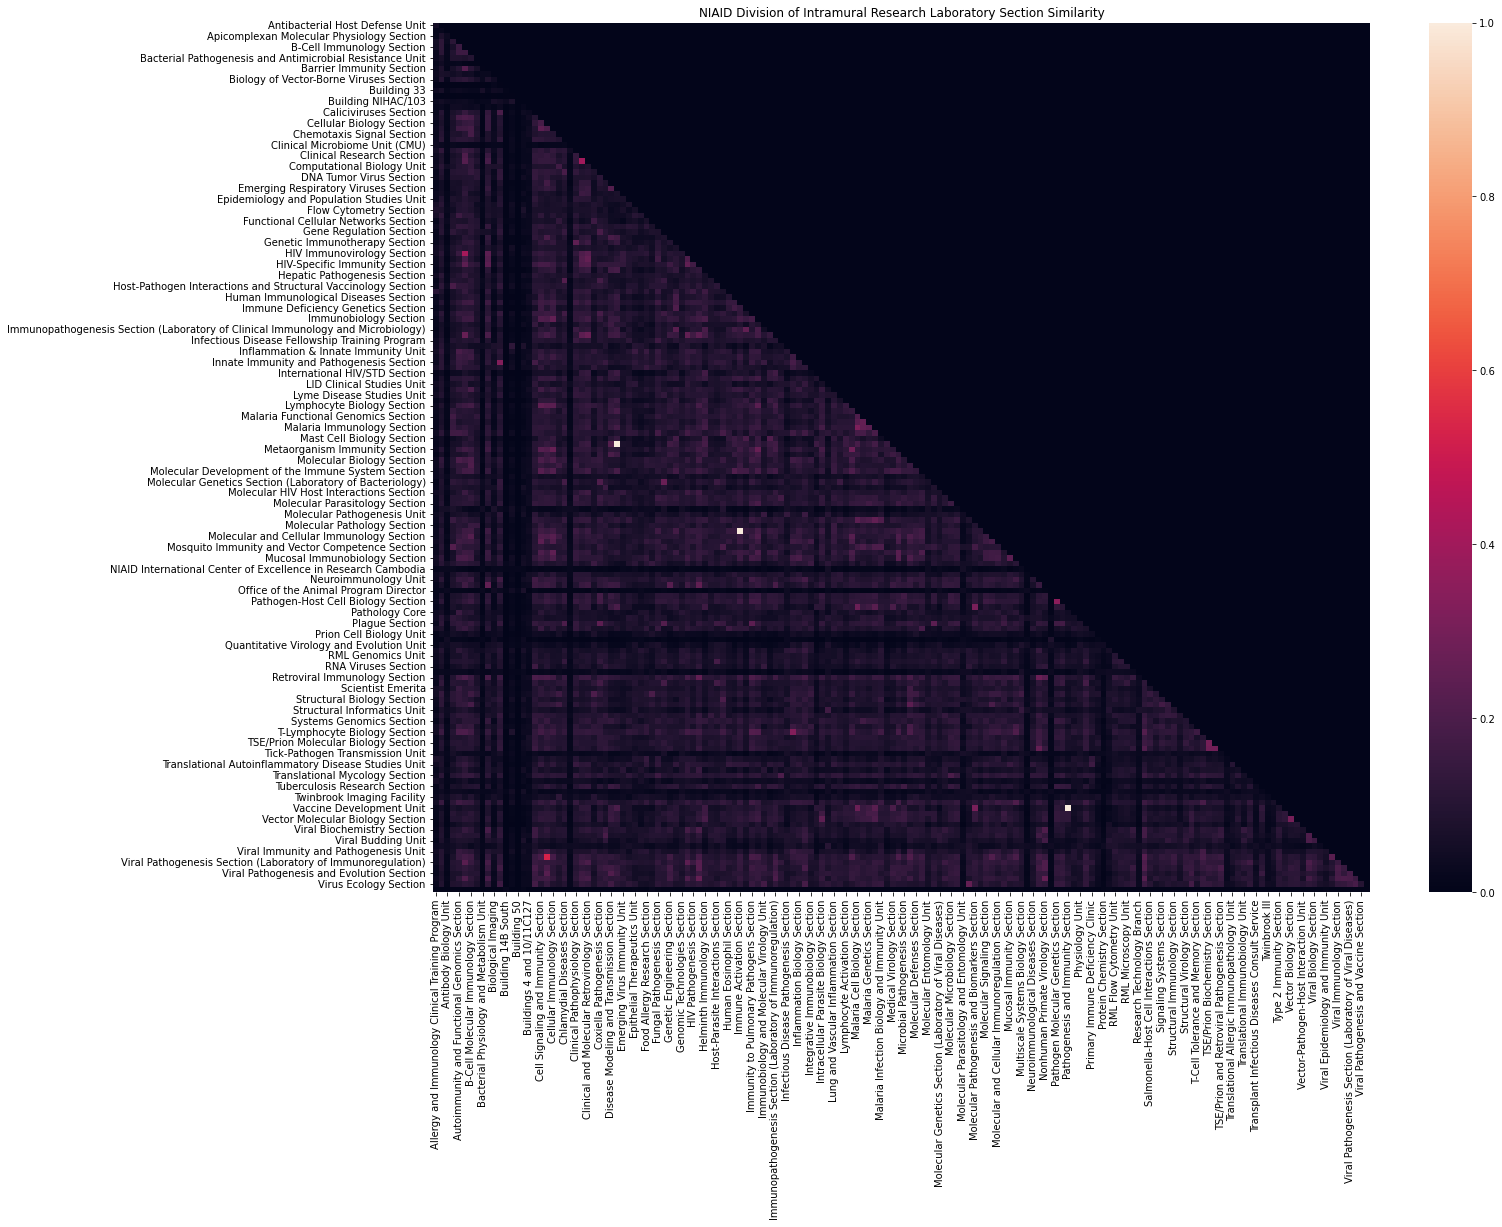

In [51]:
## fig size
plt.figure(figsize = (21,16))

## similarity
ax = sns.heatmap(
    data = data_mtrx
)

## title
ax.set_title(
    label = 'NIAID Division of Intramural Research Laboratory Section Similarity',
    fontsize = 12
)

## supress axis labels
ax.set_ylabel(
    ylabel = ''
)

ax.set_xlabel(
    xlabel = ''
)

## display
plt.show()

### Plot Subset

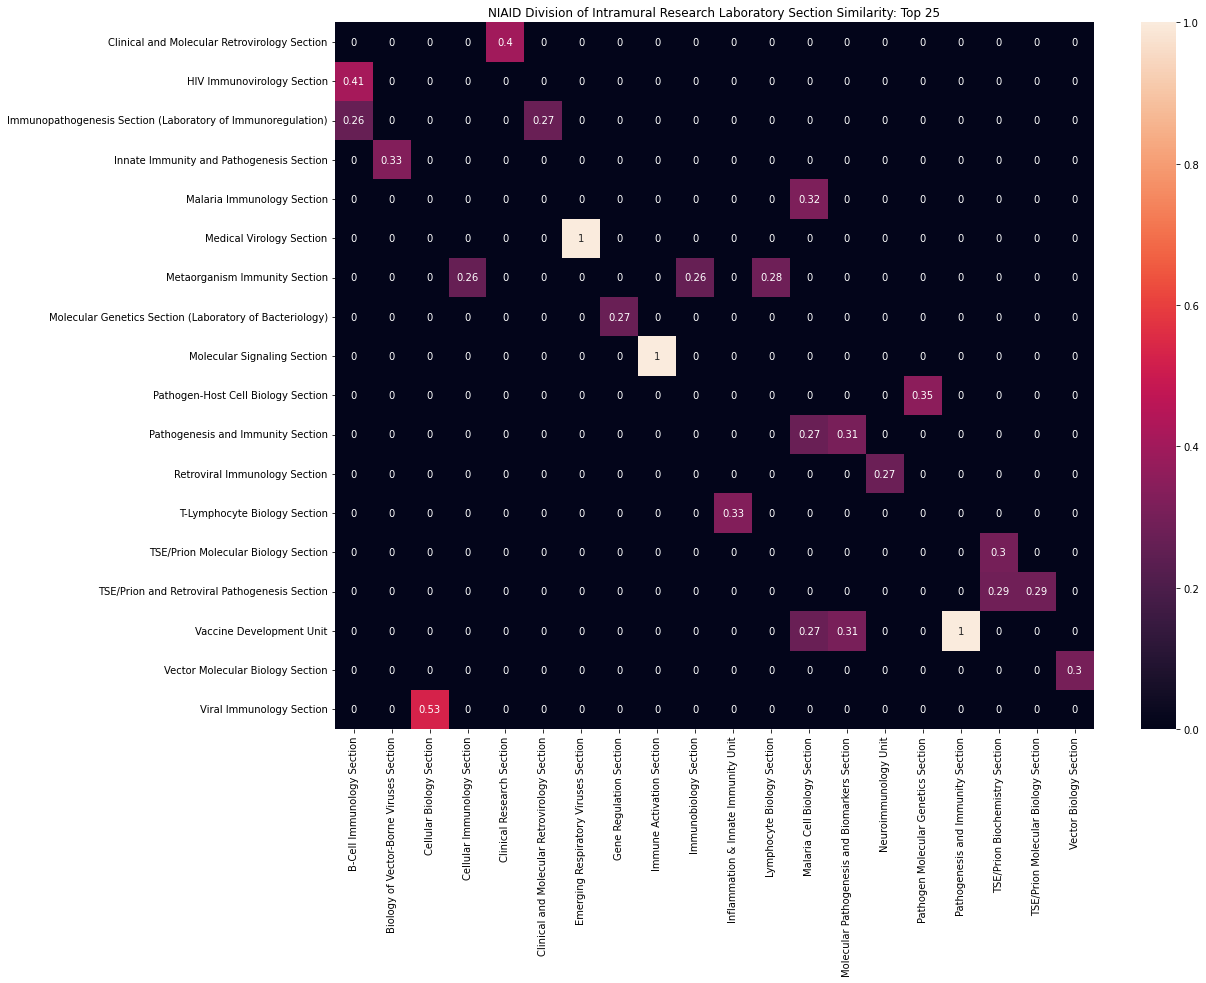

In [52]:
## fig size
plt.figure(figsize = (17,13))

## similarity
ax = sns.heatmap(
    data = data_subs_mtrx,
    annot = True
)

## title
ax.set_title(
    label = 'NIAID Division of Intramural Research Laboratory Section Similarity: Top 25',
    fontsize = 12
)

## supress axis labels
ax.set_ylabel(
    ylabel = ''
)

ax.set_xlabel(
    xlabel = ''
)

## display
plt.show()

### End